In [5]:
using CairoMakie
using Oceananigans
using Printf
using JLD2

path_name = "../../../../"
dataname = "DyeU250sonly.jld2"
filepath = path_name * dataname
setname = "U250N100Lz100g100"

"U250N100Lz100g100"

In [7]:
include("../parameters.jl")
pm = getproperty(SimParams(), Symbol(setname))

pm = merge(pm, (; Tanθ = sqrt((pm.σ^2 - pm.f^2)/(pm.Ñ^2-pm.σ^2)),
                Tanα = pm.γ * sqrt((pm.σ^2 - pm.f^2)/(pm.Ñ^2-pm.σ^2)),
                nz = round(Int,pm.Lz/2),
                m = -π/pm.Lz,
                l = sqrt(((π/pm.Lz)^2 * (pm.f^2 - pm.σ^2)) / (pm.σ^2 - pm.Ñ^2)),
                Tf = 2*π/pm.f, 
                Tσ = 2*π/pm.σ))

# last index on the slope
xlocat = 19

const gausT_center = 895                                 # gaussian paramereters for curved "corner" of slope
const gausT_width = 180
const ySlopeSame = 1336.6                           # point where planar and curved corner math up the best

ΔySlopeSame = 0

@inline heaviside(X) = ifelse(X < 0, 0., 1.) # heaviside returns 1 if x >= 0
# exponential gaussian for curved corner
@inline expcurve(y, ystar, smo) = -pm.Lz + pm.Lz * exp( - (y - ystar)^2 / (2*smo^2))
# planar slope line
@inline linslope(y) = -pm.Tanα * y
# combining the 2 with heaviside split at ySlopeSame
@inline curvedslope(y) = linslope(y) + (-linslope(y) + expcurve(y, gausT_center-ΔySlopeSame, gausT_width)) * heaviside(y-ySlopeSame)

curvedslope (generic function with 1 method)

In [12]:
yc = 2:4:5500
zc = -499:2:0
land = curvedslope.(yc)
interest_idx1 = [round(Int,(pm.Tσ*4.67)/600), round(Int,(pm.Tσ*4.81)/600), round(Int,(pm.Tσ*4.95)/600)]
tims = interest_idx1 .* 600.0
wavs = tims ./ pm.Tσ

3-element Vector{Float64}:
 4.672908123528025
 4.810346597749437
 4.947785071970849

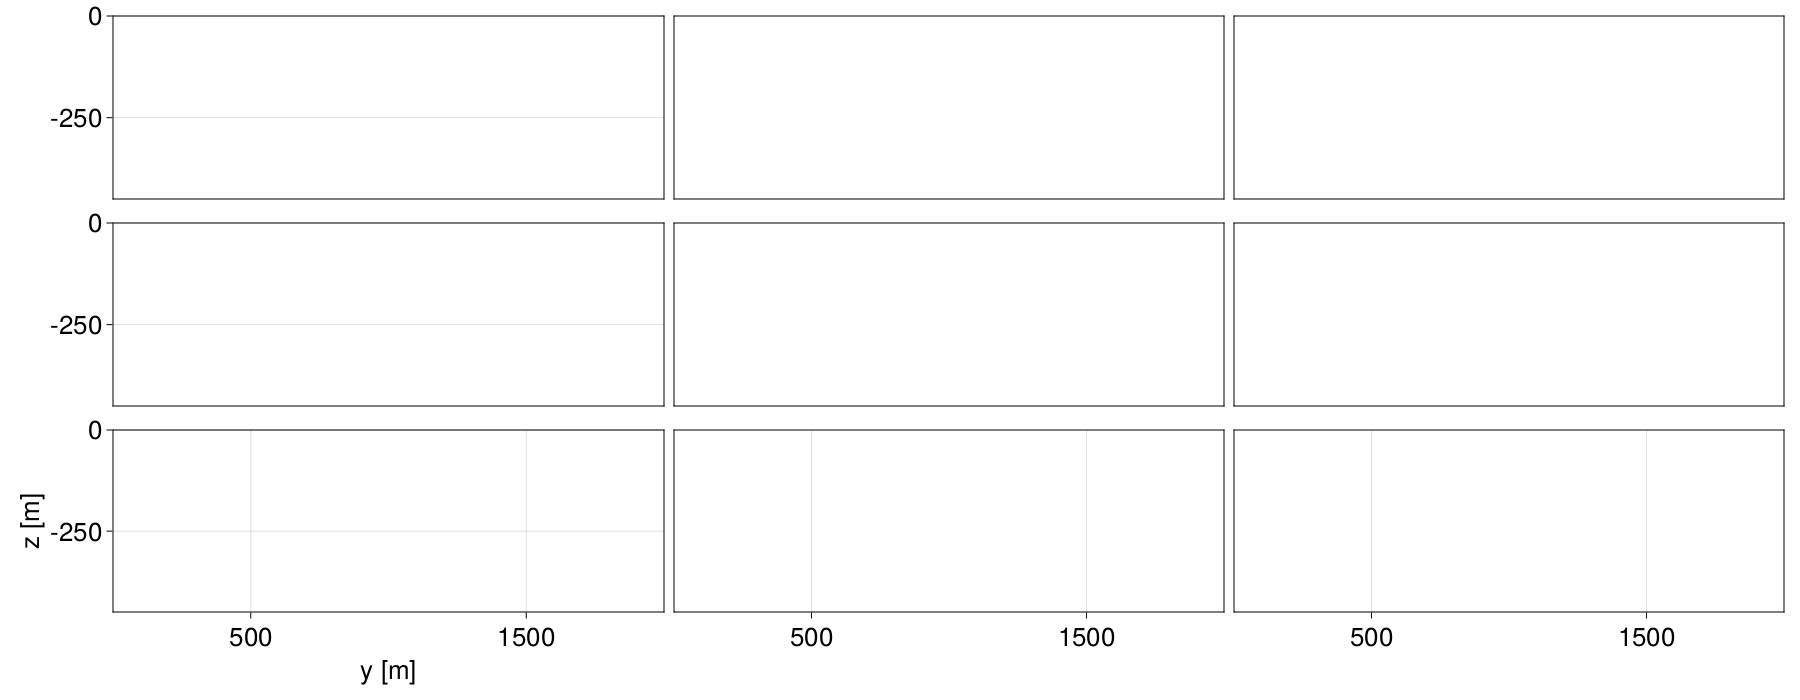

CairoMakie.Screen{IMAGE}


In [78]:
f1 = Figure(resolution = (1800, 700), fontsize=26)
ga = f1[1, 1] = GridLayout() # velocity
gb = f1[2, 1] = GridLayout() # dye
gc = f1[3, 1] = GridLayout() # dissipation  

axv1 = Axis(ga[1, 1])
axv2 = Axis(ga[1, 2])
axv3 = Axis(ga[1, 3])

axc1 = Axis(gb[1, 1])
axc2 = Axis(gb[1, 2])
axc3 = Axis(gb[1, 3])

axe1 = Axis(gc[1, 1], ylabel = "z [m]", xlabel = "y [m]")
axe2 = Axis(gc[1, 2])
axe3 = Axis(gc[1, 3])

axs = [axv1, axv2, axv3, axc1, axc2, axc3, axe1, axe2, axe3]
axv = [axv1, axv2, axv3]
axc = [axc1, axc2, axc3]
axe = [axe1, axe2, axe3]

for ax in axs
    limits!(ax, 0, 2000, -450, 0)
end

for ax in axe
    ax.xticks = 500:1000:1500
end

axv1.yticks = [-250, 0]
axc1.yticks = [-250, 0]
axe1.yticks = [-250, 0]

hidedecorations!(axv2)
hidedecorations!(axv3)
hidedecorations!(axc2)
hidedecorations!(axc3)
hidexdecorations!(axv1)
hidexdecorations!(axc1)
hideydecorations!(axe2)
hideydecorations!(axe3)

time_pre = "t = "
time_post = " Tσ"

colgap!(ga, 10)
colgap!(gb, 10)
colgap!(gc, 10)

display(f1)

In [26]:
size(yc)

(1375,)

In [27]:
size(zc)

(250,)

In [45]:
v = [ifelse(z>curvedslope(y), sin(z*y/1000)*0.1, 0.0) for y in yc, z in zc];
b = [ifelse(z>curvedslope(y), z*(3.5*1e-3)^2,0.0) for y in yc, z in zc];
c = [ifelse(z>curvedslope(y), abs(sin(z*y/100)*1e-3),0.0) for y in yc, z in zc];
e = [ifelse(z>curvedslope(y), abs(exp(z*y/100)*1e-6),0.0) for y in yc, z in zc];

In [92]:
for (p,j) in enumerate(interest_idx1)

    # get the data
    cl = log10.(clamp.(c,1e-8,1))
    el = log10.(clamp.(e,1e-8,1))

    phaselabel = time_pre * @sprintf("%0.1f", wavsa[p]) * time_post

    # create the heatmaps
    global hmv = heatmap!(axv[p], yc, zc, v, colormap = :balance, colorrange = (-pm.U₀, pm.U₀))
    contour!(axv[p], yc, zc, b, color = :black, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
    lines!(axv[p], yc, land, color=:black, lw = 4)

    global hmc = heatmap!(axc[p], yc, zc, c, colormap= :thermal, colorrange = (-4, 0),)
    contour!(axc[p], yc, zc, b, color = :white, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
    lines!(axc[p], yc, land, color=:black, lw = 4)

    global hme = heatmap!(axe[p], yc, zc, e, colormap= :thermal, colorrange = (-7, -4),)
    contour!(axe[p], yc, zc, b, color = :white, lw = 6, levels = -0.006:0.001:0, alpha = 0.5)
    lines!(axe[p], yc, land, color=:black, lw = 4)
    
    text!(axv[p], Point.(1500, -50), text = phaselabel, align = (:left, :center), color = :black, 
    font = :bold, fontsize = 35)

end

    
text!(axv[1, 1], Point.(50, -350), text = "v", align = (:left, :center), color = :black, 
    font = :bold, fontsize = 26)
text!(axc[1, 1], Point.(50, -350), text = "log₁₀c", align = (:left, :center), color = :black, 
    font = :bold, fontsize = 26)
text!(axe[1, 1], Point.(50, -350), text = "log₁₀ε", align = (:left, :center), color = :black, 
    font = :bold, fontsize = 26)

gcb1 = f1[1,2] = GridLayout()
gcb2 = f1[2,2] = GridLayout()
gcb3 = f1[3,2] = GridLayout()

# create colorbars the size of the whole data set
cb1 = Colorbar(gcb1[1,1], hmv, ticks = (-0.2:.2:0.2), size =35, label = "v [ms⁻¹]")
cb2 = Colorbar(gcb2[1,1], hmc, ticks = (-4:1:-1, ["10⁻⁴", "10⁻³", "10⁻²", "10⁻¹"] ), 
        size = 35, label = "Tracer Concentration")
cb3 = Colorbar(gcb3[1,1], hme, ticks = (-7:1:-5, ["10⁻⁴", "10⁻³", "10⁻²"] ), 
        size = 35, label = "Dissipation")

δ = pm.U₀/pm.Ñ
α = atan(pm.Tanα)
δy = δ*sin(α)
δz = δ*cos(α)
arrows!(axc[1], [250/pm.Tanα], [-250], [δy], [δz], arrowsize = 10,
    arrowcolor = :black, linecolor = :black)
text!(axc[1], Point.(50, -350), text = "log₁₀ε", align = (:left, :center), color = :black, 
    font = :bold, fontsize = 26)


Arrows{Tuple{Vector{Point{2, Float32}}, Vector{Vec{2, Float32}}}}

In [98]:
100/pm.Tanα

281.24519078682965

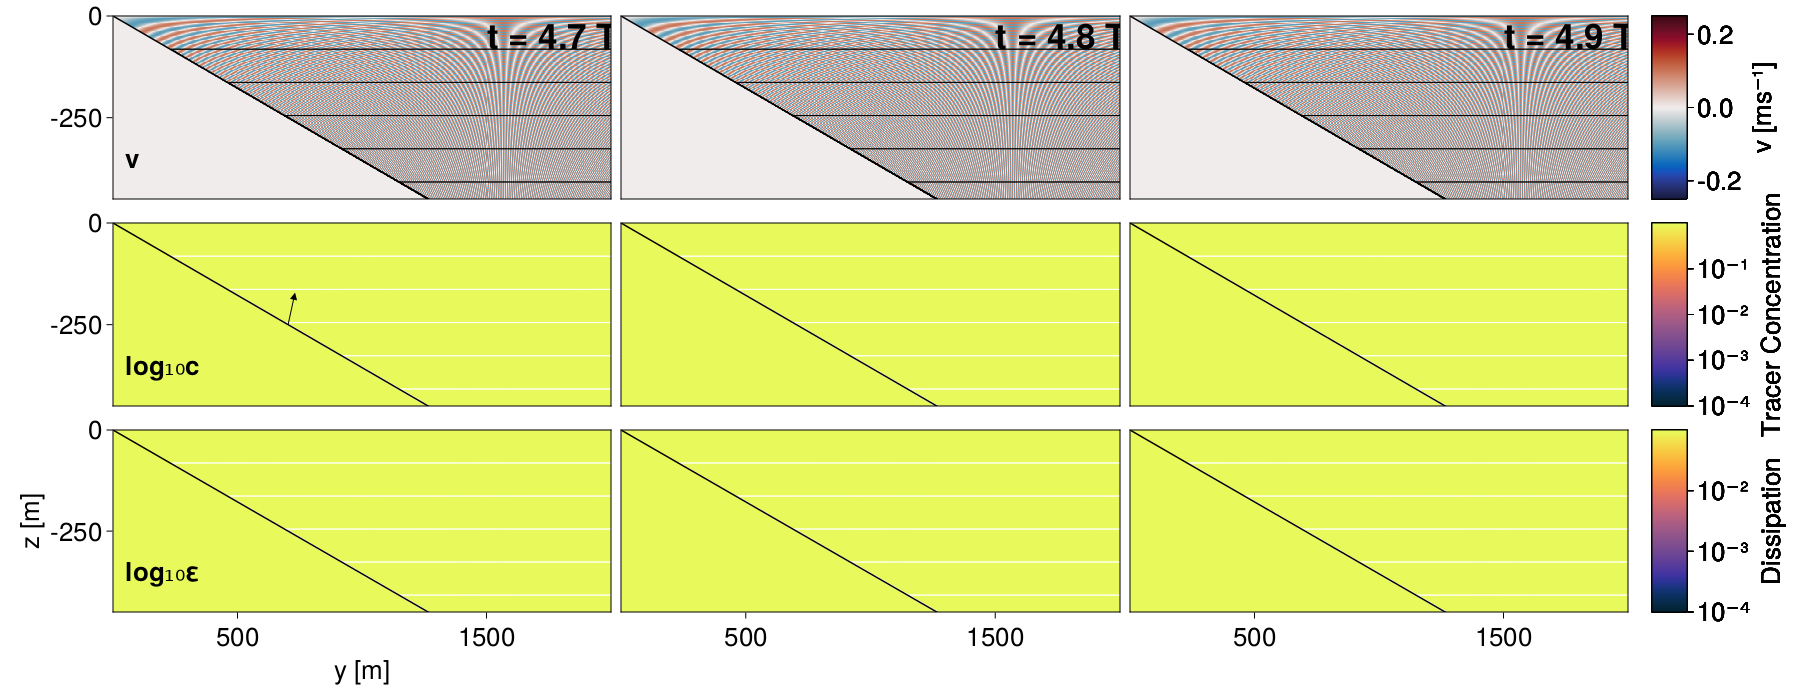

CairoMakie.Screen{IMAGE}


In [93]:
display(f1)